# <center>Model Training (Part 5)</center>

This Notbook is dedicated to training an XGBoost model to forcast the future of significant wave height time series. 

## Contents:

* Import libraries 
* Load Dataset
* Train and Test Split
* Time series cross validation Splits
* Feature Engineering
* XGBoost Model Training
* Prediction
* Model Evaluation
* Future Exploration

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)

## Load Dataset

In [ ]:
df = pd.read_pickle('../input/wavebnetwork/Stationary_Data')

In [ ]:
df_orig = df.copy()

## Train and Test Split

We partitioned the dataset into two segments: one before 2023 and the other after 2023. The portion after 2023 is designated as the test set, intentionally concealed during model training. This set will be employed to assess the model's performance and is referred to as "future" data in the code. We'll train the model on the data before 2023 using cross validation.

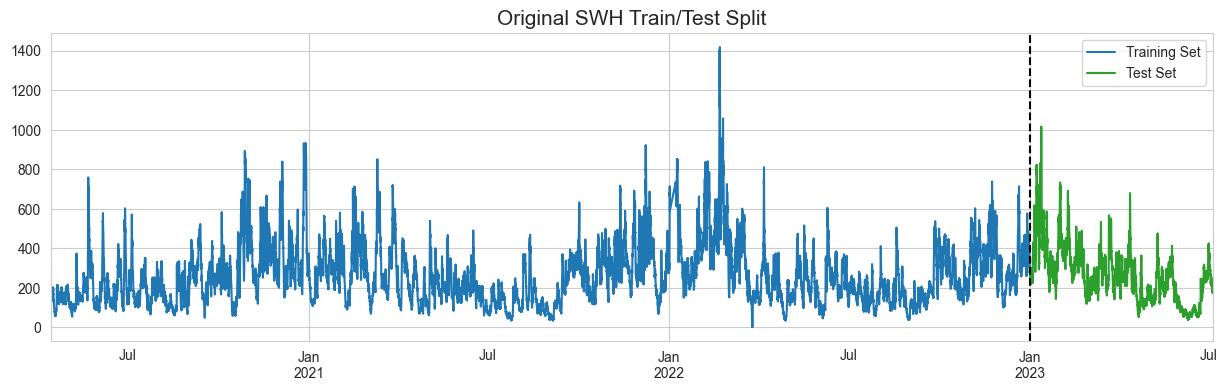

In [ ]:
# Train and test split on SWH before docomposition

train = df['SWH'].loc[df.index.year < 2023]
test = df['SWH'].loc[df.index.year >= 2023]

fig, ax = plt.subplots(figsize=(15,4))
train.plot(ax=ax, label = 'Training Set')
test.plot(ax=ax, label = 'Test Set', color=color_pal[2])
ax.axvline('01-01-2023 00:00', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set(xlabel=None)
ax.set_title('Original SWH Train/Test Split', fontsize=15)
plt.show()

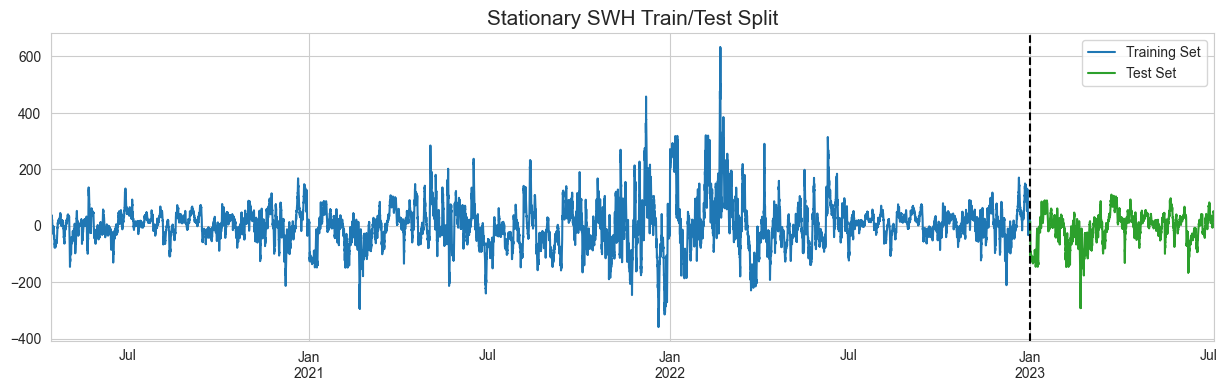

In [ ]:
# Train and test split on SWH residuals

train = df['resid'].loc[df.index.year < 2023]
test = df['resid'].loc[df.index.year >= 2023]

fig, ax = plt.subplots(figsize=(15,4))
train.plot(ax=ax, label = 'Training Set')
test.plot(ax=ax, label = 'Test Set', color=color_pal[2])
ax.axvline('01-01-2023 00:00', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set(xlabel=None)
ax.set_title('Stationary SWH Train/Test Split', fontsize=15)
plt.show()

In [ ]:
# Normalization: We skip this step since we are making prediction only based on thre time series historical data.
# avgs = df_orig.mean()
# devs = df_orig.std()

# for col in df_orig.columns:
#     df[col] = (df[col]-avgs.loc[col]) / devs.loc[col]

In [ ]:
Future = df[df.index.year>=2023]
df = df[df.index.year<2023]

## Time series cross validation Splits

With the TimeSeriesSplit class, we can specify the maximum training size and the number of desired splits. The class will then generate the necessary cross-validation partitions for us. The forcast horizon that we are interested in is 3 months.

In [ ]:
# Time series cross validation Splits
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# create time series split object
tss = TimeSeriesSplit(n_splits=5, test_size=90*24, gap=24) # Used a 24 hours gap between the split to make sure there is no overlap
df = df.sort_index()

In [ ]:
# tss is a generator. We loop over it and aplying it to the training dataset.
for train_idx, test_idx in tss.split(df):
    break
print(f"train set size: {len(train_idx)}")
print(f"test set size: {len(test_idx)}")
print(f"train + test : {len(train_idx) + len(test_idx)}")
print(f"index size: {len(df.index)}")
print(f"index - (train + test): {len(df.index)-len(test_idx)-len(train_idx)}")

train set size: 12972
test set size: 2160
train + test : 15132
index size: 23796
index - (train + test): 8664


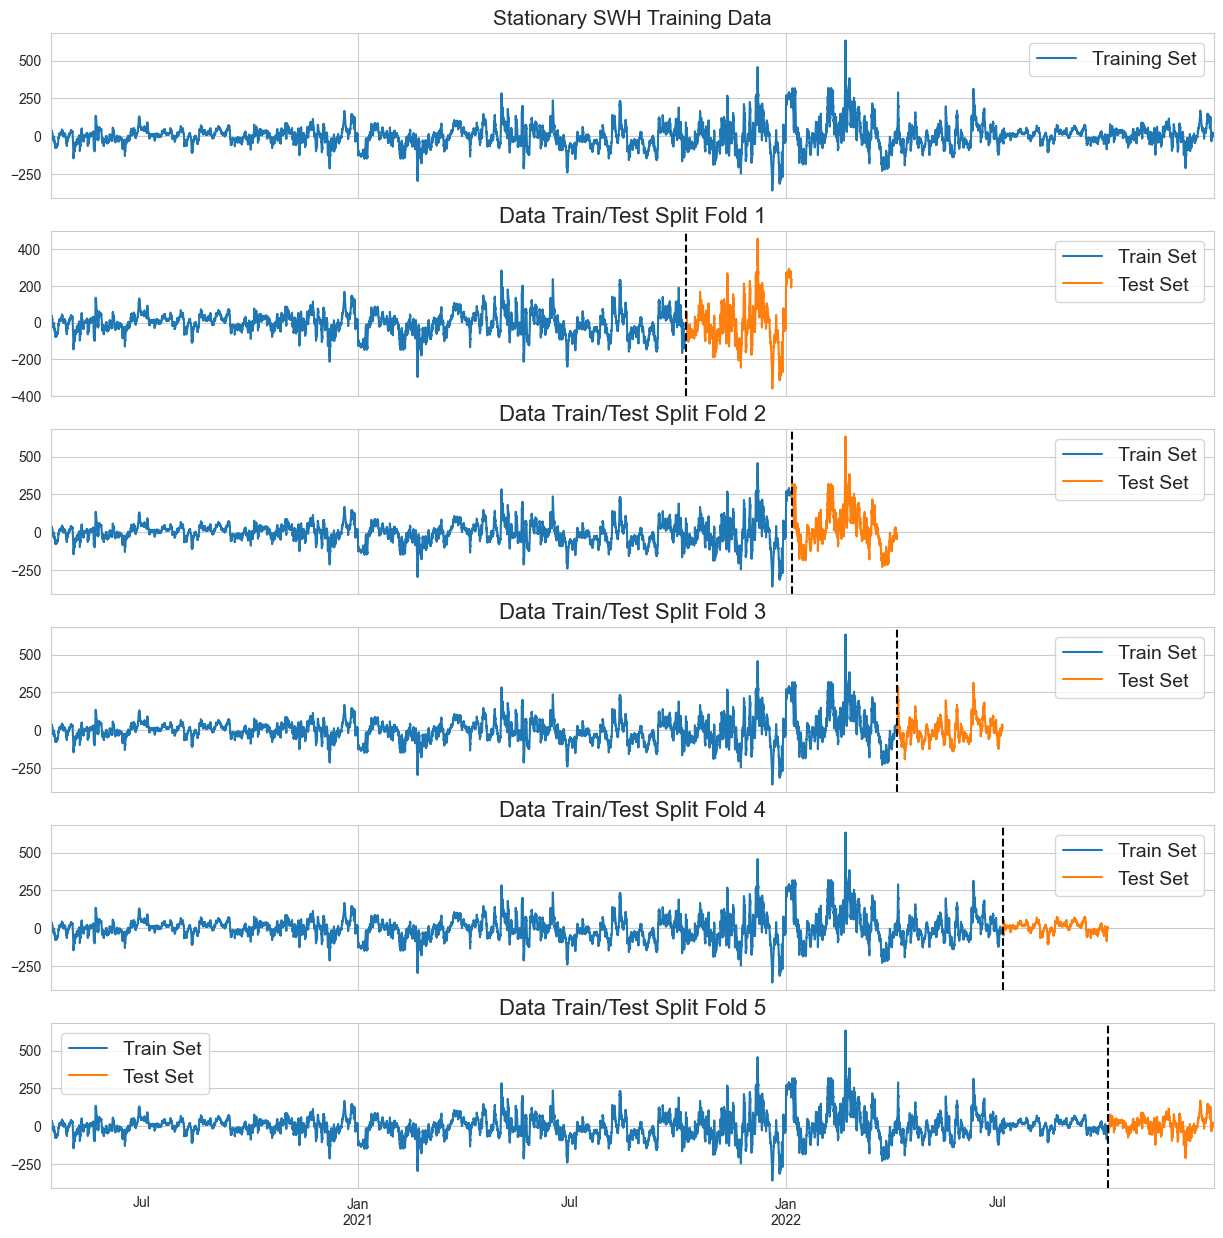

In [ ]:
# We're going to loop through this n_splits = 5 times 

fig, axs = plt.subplots(6,1, figsize=(15,15), sharex = True)

df['resid'].plot(ax=axs[0], label='Training Set') 
axs[0].set_title('Stationary SWH Training Data', fontsize=15)
axs[0].legend(fontsize=14)

fold = 1
for train_idx, test_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    train['resid'].plot(ax=axs[fold],
                         label='Train Set')
    test['resid'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(),color='black', ls='--')
    axs[fold].set(xlabel=None)
    axs[fold].set_title(f'Data Train/Test Split Fold {fold}',fontsize=16)
    axs[fold].legend(fontsize=14)
    fold += 1


plt.show()

## Feature Engineering

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['week'] = df.index.isocalendar().week.astype('int')
    #df['dayofmonth'] = df.index.day
    #df['weekofyear'] = df.index.isocalendar().week
    return df

#df = create_features(df)

In [ ]:
def add_lags(df):
    target_map = df['resid'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('730 days')).map(target_map)
    return df

#df = add_lags(df)

## XGBoost Model Training

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=90*24, gap=24)
df = df.sort_index()

df = create_features(df)
df= add_lags(df)

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = ['hour', 'quarter', 'month', 'year', 'dayofyear', 'week', 'lag1', 'lag2']
    TARGET = 'resid'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[16:05:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:57.51026	validation_1-rmse:122.20461
[100]	validation_0-rmse:41.67899	validation_1-rmse:64.32501
[200]	validation_0-rmse:36.84348	validation_1-rmse:51.89113
[300]	validation_0-rmse:34.11716	validation_1-rmse:49.50984
[400]	validation_0-rmse:32.48508	validation_1-rmse:46.80965
[500]	validation_0-rmse:31.32212	validation_1-rmse:45.88814
[600]	validation_0-rmse:30.25353	validation_1-rmse:45.70767
[700]	validation_0-rmse:29.43887	validation_1-rmse:45.43793
[800]	validation_0-rmse:28.50678	validation_1-rmse:45.16491
[900]	validation_0-rmse:27.62459	validation_1-rmse:44.90891
[999]	validation_0-rmse:26.92106	validation_1-rmse:44.67280
[16:05:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/obj

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 37.0227
Fold scores:[44.613607660656285, 33.037929156082996, 69.26030783355473, 23.838787788528617, 14.363058553098915]


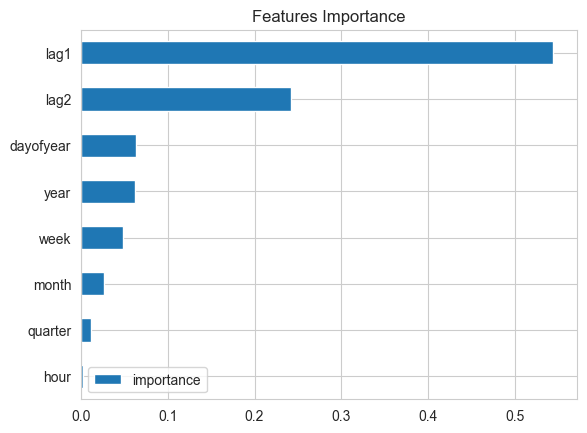

In [ ]:
fi = pd.DataFrame(data = reg.feature_importances_,
                  index = reg.feature_names_in_,
                  columns = ['importance'])
fi.sort_values('importance').plot(kind='barh', title='Features Importance')
plt.show()

In [ ]:
# Retrain on all data
#df = create_features(df)

FEATURES = ['hour', 'day', 'quarter', 'month', 'year', 'dayofyear', 'week', 'lag1', 'lag2']
TARGET = 'resid'

X_all = df[FEATURES]
y_all = df[TARGET]

regA = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
regA.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[16:05:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:73.90347
[100]	validation_0-rmse:45.29230
[200]	validation_0-rmse:36.18152
[300]	validation_0-rmse:32.93863
[400]	validation_0-rmse:31.11356
[499]	validation_0-rmse:29.82651


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

To Make Prediction it's important first connect the future dates to the current data. That's because to find the lag feature we need the current data. Therefore first we connect the future data andthen recreate the lag feature so we'll have them for the future data created based on the current data as well.

## Prediction

In [ ]:
# combine test/future dataset with the training data

Future['isfuture'] = True
df['isfuture'] = False
df_and_future = pd.concat([df, Future])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
# store the future data in a new dataframe which includes all added features as well

future_w_features = df_and_future.query('isfuture').copy()

In [ ]:
future_w_features['resid_pred'] = regA.predict(future_w_features[FEATURES])

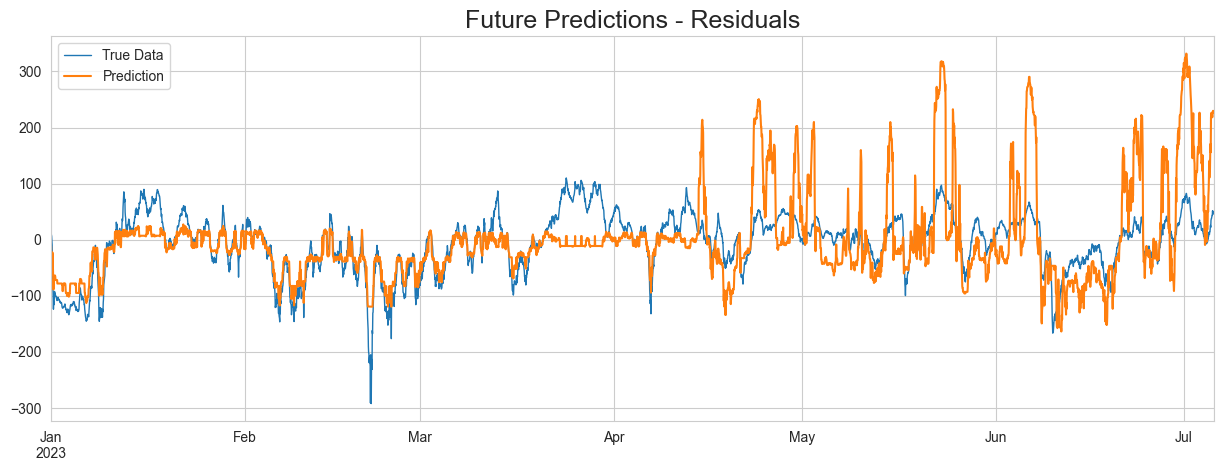

In [ ]:
ax = future_w_features['resid'].plot(figsize=(15, 5),
                                     color=color_pal[0],
                                     label='True Data',
                                     ms=1,
                                     lw=1)
future_w_features['resid_pred'].plot(ax=ax,
                               color=color_pal[1],
                               label='Prediction')

ax.set_title('Future Predictions - Residuals', fontsize=18)
ax.set(xlabel=None)
ax.legend()
plt.show()

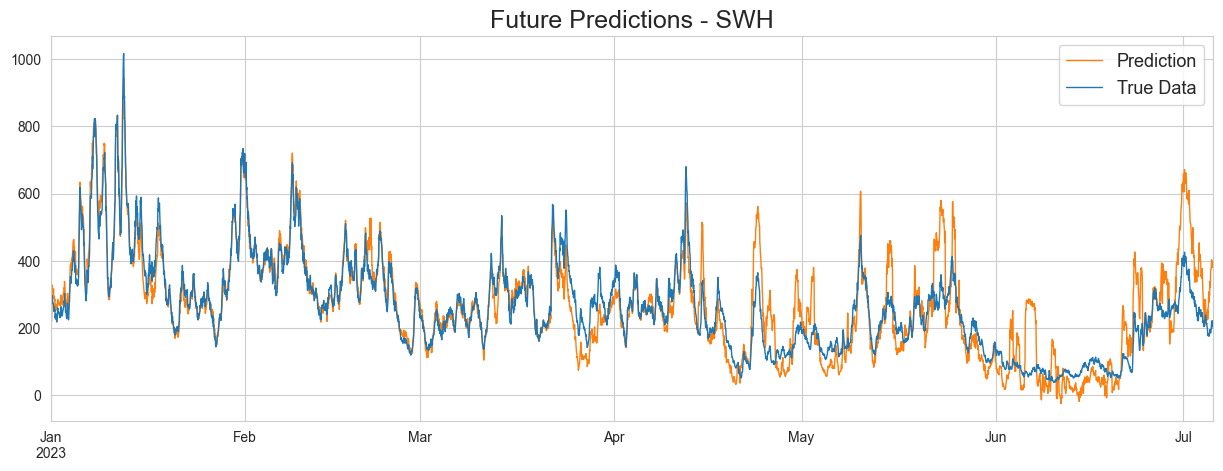

In [ ]:
future_w_features['SWH_pred'] = future_w_features['resid_pred']+future_w_features['trend']+future_w_features['seasonal']
SWH = future_w_features['SWH']

ax = future_w_features['SWH_pred'].plot(figsize=(15, 5),
                      color=color_pal[1],
                      label='Prediction',
                      ms=1,
                      lw=1)
SWH.plot(ax=ax,
         color=color_pal[0],
         label='True Data',
         ms=1,
         lw=1)

ax.set_title('Future Predictions - SWH', fontsize=18)
ax.set(xlabel=None)
ax.legend(fontsize=13)
plt.show()

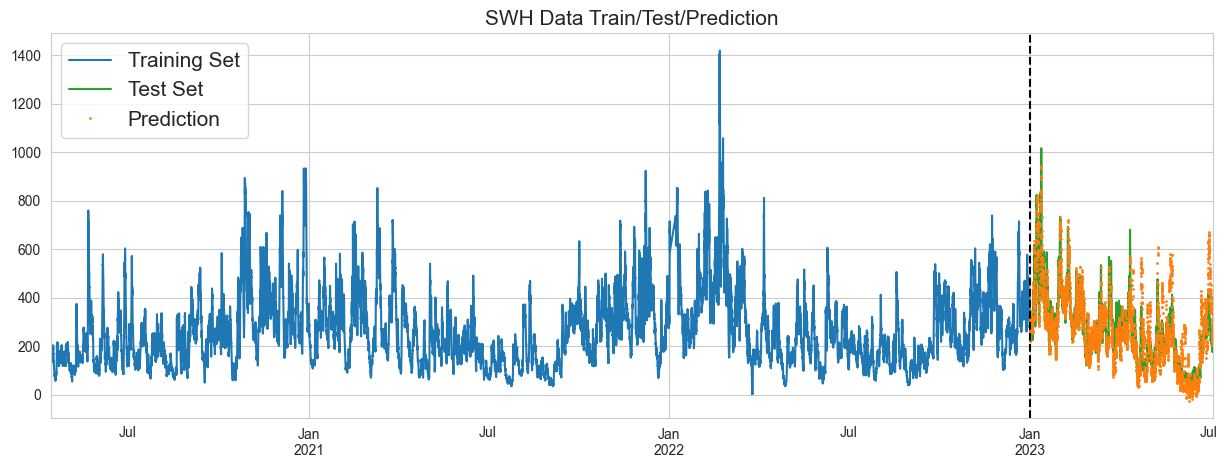

In [ ]:
train = df_orig['SWH'].loc[df_orig.index.year < 2023]
test = df_orig['SWH'].loc[df_orig.index.year >= 2023]

fig, ax = plt.subplots(figsize=(15,5))

train.plot(ax=ax, label = 'Training Set')
test.plot(ax=ax, label = 'Test Set', color=color_pal[2])
future_w_features['SWH_pred'].plot(ax=ax, label = 'Prediction', color=color_pal[1], style='.', markersize=2)
ax.axvline('01-01-2023 00:00', color='black', ls='--')
ax.legend(fontsize=15)
ax.set(xlabel=None)
ax.set_title('SWH Data Train/Test/Prediction', fontsize=15)
plt.show()

## Model Evaluation

In [ ]:
future_w_features

,PeakPeriod,PeakDirection,UpcrossPeriod,SWH,Hmax,THmax,resid,seasonal,trend,hour,day,quarter,month,year,dayofyear,week,lag1,lag2,isfuture,resid_pred,SWH_pred
time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,12.562222,346.161111,8.071778,279.266667,440.0,1.151111,13.778441,12.310173,253.178053,0,1,1,1,2023,1,52,-23.991387,11.263023,True,-11.468102,254.020123
2023-01-01 01:00:00+00:00,12.277778,339.005556,8.086889,284.933333,394.0,1.054444,8.684378,23.076594,253.172361,1,1,1,1,2023,1,52,-13.073811,6.169014,True,-37.882000,238.366955
2023-01-01 02:00:00+00:00,12.136111,349.269444,7.986417,274.980556,415.5,0.975556,6.485570,15.328316,253.166669,2,1,1,1,2023,1,52,-8.361069,3.970260,True,-40.910580,227.584406
2023-01-01 03:00:00+00:00,12.687778,315.727778,8.003000,278.877778,430.0,1.510556,-3.534457,29.251257,253.160978,3,1,1,1,2023,1,52,13.113361,-6.049713,True,-62.447956,219.964278
2023-01-01 04:00:00+00:00,13.650000,352.827778,8.167667,279.361111,409.0,0.926111,-9.401668,35.607494,253.155286,4,1,1,1,2023,1,52,25.687874,-11.916870,True,-50.205082,238.557698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-05 15:00:00+00:00,7.758333,289.405556,5.625778,221.655556,339.5,1.480000,51.410740,-56.801729,227.046545,15,5,3,7,2023,186,27,-44.824561,-151.385627,True,227.936325,398.181141
2023-07-05 16:00:00+00:00,7.936667,298.661111,5.507889,212.650000,331.0,0.811667,45.046919,-59.437532,227.040613,16,5,3,7,2023,186,27,-36.075200,-142.195026,True,225.983002,393.586083
2023-07-05 17:00:00+00:00,8.033333,303.922222,5.493056,217.205556,321.0,0.813889,50.469898,-60.299023,227.034680,17,5,3,7,2023,186,27,-48.815235,-129.397523,True,229.809189,396.544846


In [ ]:
# 6 month prediction Error

score = np.sqrt(mean_squared_error(future_w_features['SWH'], future_w_features['SWH_pred']))
print(f"RMSE Score on Test Set: {score:.2f}")

RMSE Score on Test Set: 64.59


In [ ]:
# 3 month(forcast horizon) prediction error

score = np.sqrt(mean_squared_error(future_w_features[future_w_features.index < '2023-04-01']['SWH'], 
                                   future_w_features[future_w_features.index < '2023-04-01']['SWH_pred']))
print(f"RMSE Score on Test Set: {score:.2f}")

RMSE Score on Test Set: 36.51


In [ ]:
# baseline error by predicting SWH to be exactly the same as last year this time.

score = np.sqrt(mean_squared_error(df_and_future[(df_and_future.index >= '2022-01-01')
                                                    &(df_and_future.index < '2022-04-01')]['SWH'], 
                                   future_w_features[future_w_features.index < '2023-04-01']['SWH_pred']))
print(f"Baseline Model RMSE Score on Test Set: {score:.2f}")

Baseline Model RMSE Score on Test Set: 196.18


## Future Exploration

* Incorporate additional time series variables' influence that we omitted during the data cleaning phase.
* Explore complex seasonal patterns that may be concealed.